In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
grid_path = os.path.join(os.path.dirname(os.getcwd()), "data", "interim", "grid_data.npy")

# Loading it ...
with open(grid_path, 'rb') as f:
    data = np.load(f)

data.shape

(76, 79, 8736, 11)

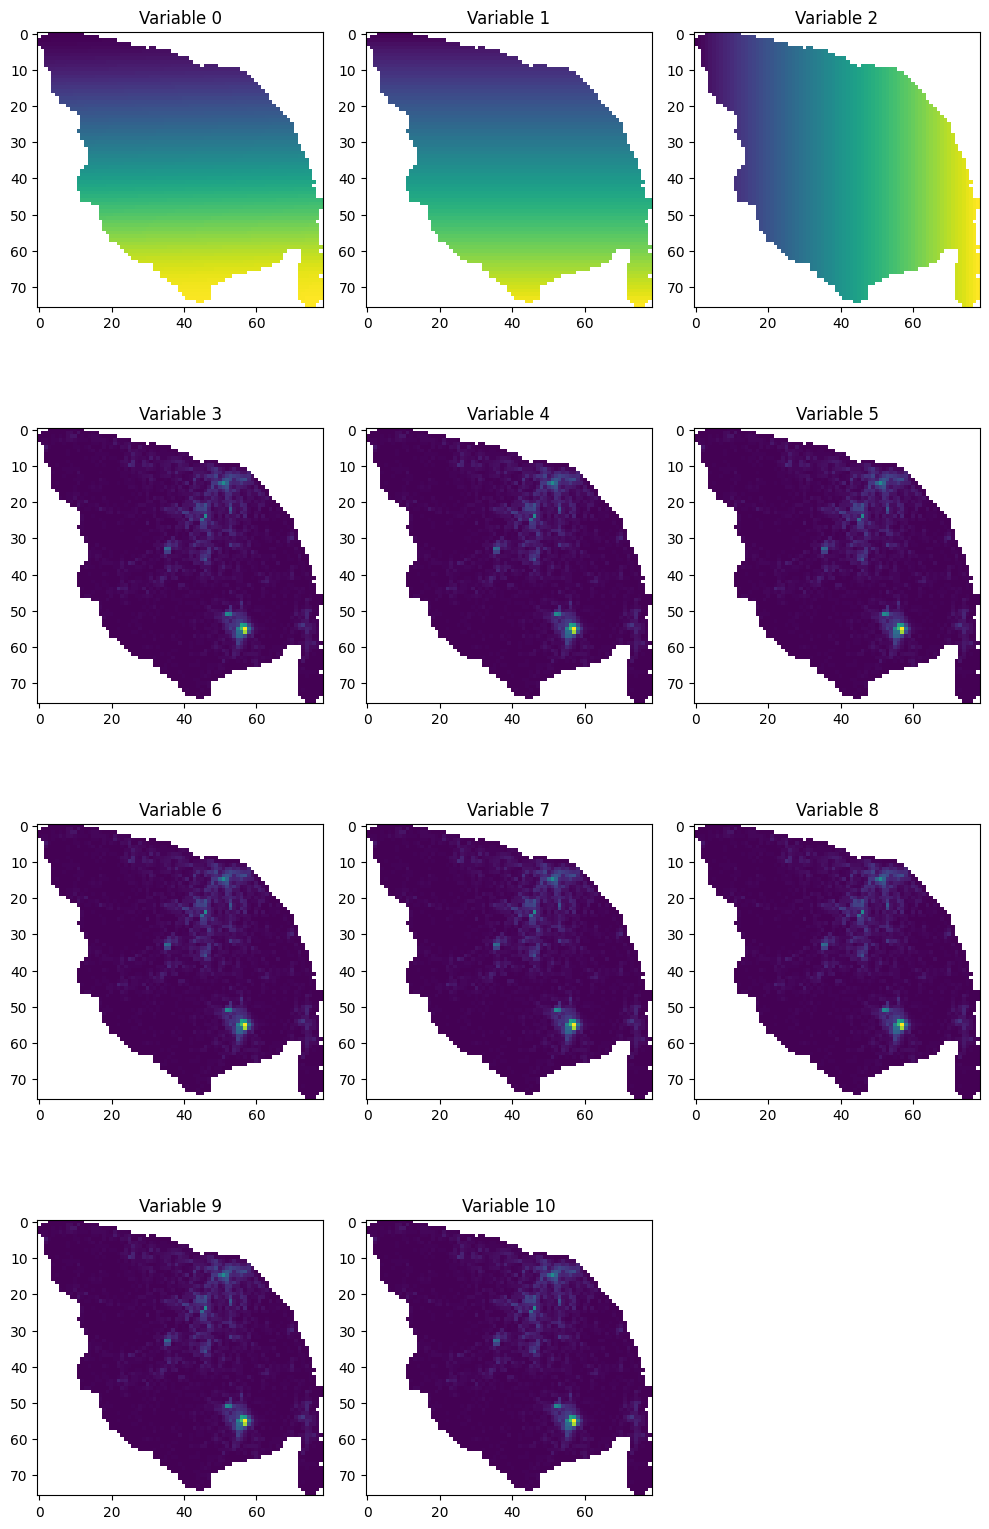

In [3]:
def plot_picture(grid_data, timestamp_index):
    num_vars = grid_data.shape[-1]
    num_rows = int((num_vars + 2) / 3)
    fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(10, 4*num_rows))
    var_list = range(num_vars)
    for var, ax in zip(var_list, axes.flatten()):
        if var < num_vars:
            ax.imshow(grid_data[:,:,timestamp_index,var], interpolation='nearest')
            ax.set_title(f'Variable {var}')
        else:
            ax.axis('off')
    if num_vars % 3 != 0:
        fig.delaxes(axes.flatten()[-1])
    plt.tight_layout()
    plt.show()
    return fig

show_plot = True

if show_plot:
    fig = plot_picture(grid_data = data, timestamp_index = 1000)

In [4]:
cell_ids = data[...,0,0]
relevant_cells_maks = ~np.isnan(cell_ids)

Model definition and train

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense

def CNN_LSTM(input_shape, output_shape):
    ## Predicting the value of C1 for all the cells for only 1 timeStamp ahead (may be a waste for grid elements of no interest)
    model = tf.keras.Sequential()
    # define CNN model
    model.add(TimeDistributed(Conv2D(4, (2,2), activation='relu', padding='same', input_shape=input_shape)))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    model.add(TimeDistributed(Conv2D(1, (2,2), activation='relu', padding='same')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    model.add(TimeDistributed(Flatten()))
    # define LSTM model
    model.add(LSTM(units=25))
    # Final output - prediction for t+1 for each cell ID
    model.add(Dense(output_shape))

    model.build(input_shape) # input_shape is the shape of the input data
    model.summary()

    return model

2023-04-16 18:13:34.582732: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-16 18:13:34.586457: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-16 18:13:34.669113: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-16 18:13:34.670919: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-16 18:13:36.185817: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [6]:
# Setting the timestep dim as the first dimensions
data = np.transpose(data, (2, 0, 1, 3))
print(f'Whole dataset shape: {data.shape}')

Whole dataset shape: (8736, 76, 79, 11)


In [7]:
# temporal size of the input?

#Predicting next hour? hours? day?
# Separate models to be trainined efficiently?

#model 1 - Predicts the next hour
#model 2 - Predict the next half of the day
#model 3 . Precits for the next day

# method to extract data for training?
#generator?


In [8]:
######## model 1 - 24 h -> 15 min ahead ###########
# QUESTION: Is it better to use 24h or 12h?

# number of 15 min chuncks in 24 h
n_in_24h = 24*4

# number of 15 min chuncks in 1 h
n_in_1h = 4

# hourly step
step = 2*n_in_1h # QUESTION - this is 2 hours, not 1 hour, right?

# This is only getting 200 samples, more than that can take a lot of memory, 
# maybe we should create a generator method that takes data from the data
# array and sends it to the training ... 
# OR appying pre-processing for dimensionaly reduction ...

n_samples = 50
# input
x = np.stack([data[step*i:step*i + n_in_24h,...,3:] for i in range(n_samples)]) # QUESTION - why only the last 8 features and not the complete 11?

size_of_y = 1
# label - predicting only 1 timeStamp ahead (15 min in the future)
y = np.stack([data[step*i+n_in_24h :step*i + n_in_24h + size_of_y,:, :,3][0][relevant_cells_maks] for i in range(n_samples)])

In [9]:
# create generator to slide thought the data sending data for training ? Is it worth doing?

# the shape is: (sample, lat, lon, times, var)
print(f'X shape: {x.shape}')

# Flattening cell_id from a grid to a vector
# the shape is: (sample, cell_id)
print(f'Y shape: {y.shape}')

X shape: (50, 96, 76, 79, 8)
Y shape: (50, 3743)


In [10]:
x[np.isnan(x)] = 0

In [11]:
assert np.isnan(x).sum() == 0
assert np.isnan(y).sum() == 0

In [12]:
train_split = 0.9
x_train, x_test = x[:int(n_samples*train_split)], x[int(n_samples*train_split):]
y_train, y_test = y[:int(n_samples*train_split)], y[int(n_samples*train_split):]

In [13]:
# Define custom loss function w/ mask for values without interest? 
# Or predict directly for the cell_ids?

In [14]:
input_shape = (None,96,76,79,8)
output_shape = relevant_cells_maks.sum()
model =CNN_LSTM(input_shape, output_shape)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2) # 1e-2
loss = tf.keras.losses.MeanSquaredError()
model.compile(optimizer=optimizer, loss=loss)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 96, 76, 79, 4)    132       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 96, 38, 39, 4)    0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 96, 38, 39, 1)    17        
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 96, 19, 19, 1)    0         
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 96, 361)          0

2023-04-16 18:13:44.376619: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-16 18:13:44.380953: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-16 18:13:44.384187: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [15]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), \
    batch_size=4, epochs=100)


Epoch 1/100


2023-04-16 18:13:48.248350: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-16 18:13:48.252173: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-16 18:13:48.256481: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

12/12 [==============================] - ETA: 0s - loss: 124.9976

2023-04-16 18:13:55.011693: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-16 18:13:55.014771: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-16 18:13:55.017634: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

12/12 [==============================] - 8s 260ms/step - loss: 124.9976 - val_loss: 211.1616
Epoch 2/100
12/12 [==============================] - 2s 151ms/step - loss: 118.8095 - val_loss: 202.8500
Epoch 3/100
12/12 [==============================] - 2s 157ms/step - loss: 112.8599 - val_loss: 194.5352
Epoch 4/100
12/12 [==============================] - 2s 162ms/step - loss: 107.3116 - val_loss: 187.2522
Epoch 5/100
12/12 [==============================] - 2s 148ms/step - loss: 102.4226 - val_loss: 180.8162
Epoch 6/100
12/12 [==============================] - 2s 152ms/step - loss: 98.3419 - val_loss: 174.8528
Epoch 7/100
12/12 [==============================] - 2s 143ms/step - loss: 94.6411 - val_loss: 169.8118
Epoch 8/100
12/12 [==============================] - 2s 131ms/step - loss: 91.3580 - val_loss: 165.2473
Epoch 9/100
12/12 [==============================] - 2s 145ms/step - loss: 88.3900 - val_loss: 160.7376
Epoch 10/100
12/12 [==============================] - 2s 137ms/step - l

dict_keys(['loss', 'val_loss'])


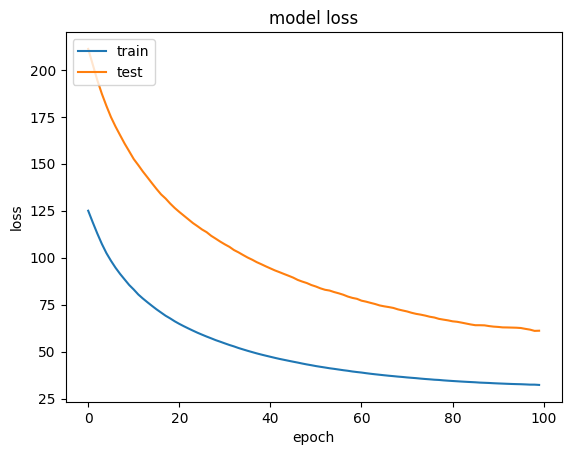

In [16]:
# QUESTION: Use the model in a recursive way? 


# list all data in history
print(history.history.keys())

# summarize history for loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:
# Model prediction

pred = model.predict(x_test[0:1,...])
ground_truth =y_test[0:1,...]


2023-04-16 18:16:45.201902: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-16 18:16:45.205739: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-16 18:16:45.208101: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 1s 697ms/step


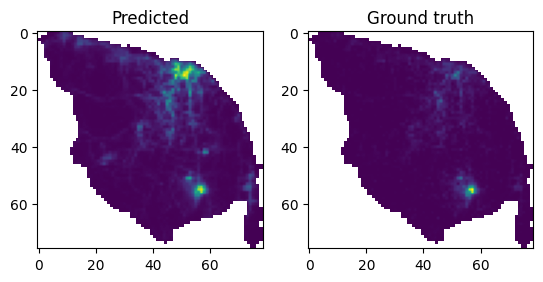

In [18]:
import pandas as pd 

grid_info = os.path.join(os.path.dirname(os.getcwd()), "data", "raw", "ficheiros_WDL", "DISPOSITIVOS MOVEIS_QUADRICULAS", "DISPOSITIVOS MOVEIS_QUADRICULAS.xlsx")


# Create the 2d grid
dfs_grid = pd.read_excel(grid_info, sheet_name='em bruto', engine='openpyxl')
to_keep = ['grelha_x', 'grelha_y', 'wkt', 'grelha_id']

dfs_grid_filtered = dfs_grid[to_keep]
del(dfs_grid)

# grid indexs
grelha_x = dfs_grid_filtered['grelha_x'].values -1
grelha_y = dfs_grid_filtered['grelha_y'].values -1
grelha_id =  dfs_grid_filtered['grelha_id'].values 

grelha_id_2d = np.empty((grelha_y.max() +1, grelha_x.max()+1))
grelha_id_2d[:] = np.nan
pred_2d = grelha_id_2d.copy()
ground_truth_2d = grelha_id_2d.copy()

# Indices to map from
idx_2d = np.stack([grelha_y, grelha_x])

# Assign the elements to the regular rectangular grid

grelha_id_2d[tuple(idx_2d)] = grelha_id.ravel()
pred_2d[tuple(idx_2d)] = pred.ravel()
ground_truth_2d[tuple(idx_2d)] = ground_truth.ravel()


fig, axs = plt.subplots(1,2)

axs[0].set_title('Predicted')
axs[0].imshow(pred_2d)

axs[1].set_title('Ground truth')
axs[1].imshow(ground_truth_2d)

# axs[2].set_title('Error (%)')
# axs[2].imshow((pred_2d-ground_truth_2d)/(ground_truth_2d))

In [19]:
from sklearn.metrics import mean_squared_error
from scipy import stats

truth_stats = stats.describe(ground_truth.flatten())
pred_stats = stats.describe(pred.flatten())

print("RESULTS")
print("MSE:", mean_squared_error(ground_truth, pred))
print("Ground Truth Stats:", truth_stats)
print("Predictions Stats: ", pred_stats)

RESULTS
MSE: 35.55237570743524
Ground Truth Stats: DescribeResult(nobs=3743, minmax=(0.0, 218.8600006103516), mean=3.7712565688450366, variance=98.76027359707909, skewness=9.94405118640492, kurtosis=155.57140037978806)
Predictions Stats:  DescribeResult(nobs=3743, minmax=(-0.072455846, 81.452896), mean=4.0038886, variance=64.11113767557639, skewness=4.746612090995969, kurtosis=28.87957462676252)


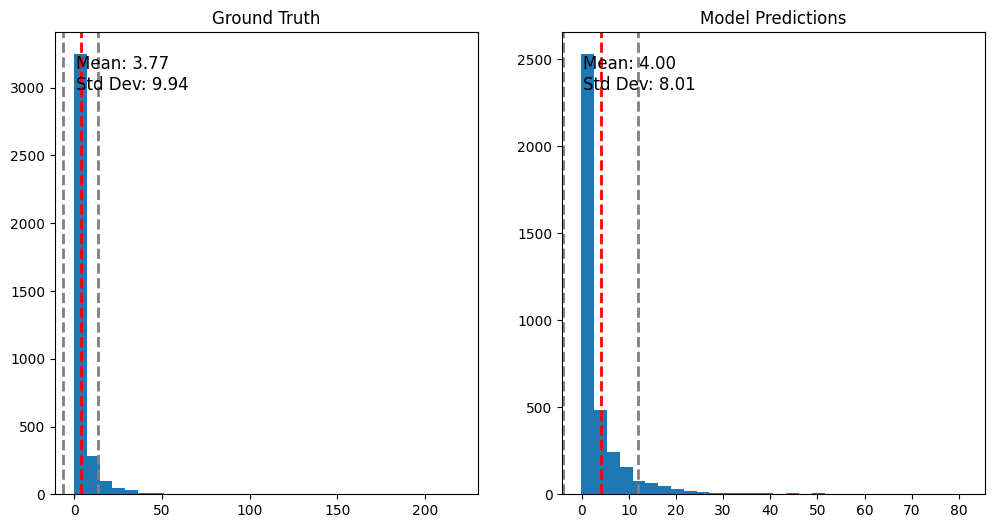

In [20]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

ax1.hist(ground_truth.flatten(), bins=30)
ax1.set_title('Ground Truth')
ax1.axvline(truth_stats.mean, color='red', linestyle='dashed', linewidth=2)
ax1.axvline(truth_stats.mean - truth_stats.variance**0.5, color='gray', linestyle='dashed', linewidth=2)
ax1.axvline(truth_stats.mean + truth_stats.variance**0.5, color='gray', linestyle='dashed', linewidth=2)
ax1.text(0.05, 0.95, f"Mean: {truth_stats.mean:.2f}\nStd Dev: {truth_stats.variance**0.5:.2f}", transform=ax1.transAxes, fontsize=12, verticalalignment='top')

ax2.hist(pred.flatten(), bins=30)
ax2.set_title('Model Predictions')
ax2.axvline(pred_stats.mean, color='red', linestyle='dashed', linewidth=2)
ax2.axvline(pred_stats.mean - pred_stats.variance**0.5, color='gray', linestyle='dashed', linewidth=2)
ax2.axvline(pred_stats.mean + pred_stats.variance**0.5, color='gray', linestyle='dashed', linewidth=2)
ax2.text(0.05, 0.95, f"Mean: {pred_stats.mean:.2f}\nStd Dev: {pred_stats.variance**0.5:.2f}", transform=ax2.transAxes, fontsize=12, verticalalignment='top')

plt.show()